# Analyse de données  <a class="tocSkip">

L'objectif de ce notebook est de mieux comprendre les données et analyses de l'article *Mutation dynamics and fitness effects followed in single cells*, par Lydia Robert, Jean Ollion, Jerome Robert, Xiaohu Song, Ivan Matic et Marina Elez (Science, 2018).

# Data exploration

In [1]:
library("gridExtra")
library("ggplot2")


## Mutation Accumulation experiment : data_microMA
### Files description

On se base sur les données fournies en annexe de l'article, ainsi que leur description.

The folder contains 4 files giving the evolution of growth rate during one representative $\mu$MA experiment for 4 different strains, *mutH*, *mutT*, WT, MF1 (dataset_microMA_...) . Each column contains the values of one variable (time, generation or growth rate) for each time step for the mother cell of a single microchannel. The first two lines (i.e. first two values for each column) give respectively the index of the field of view and the index of the microchannel (~15channels for each field of view).

In [2]:
microMA_WT <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_WT.csv")
microMA_MutH <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv")
microMA_MutT <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MutT.csv")
microMA_MF1 <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MF1.csv")

# Split the channel information (first 2 lines) from the growth rates
microMA_WT_channels <- microMA_WT[c(1,2),]
microMA_WT <- microMA_WT[-c(1,2),]
microMA_MutH_channels <- microMA_MutH[c(1,2),]
microMA_MutH <- microMA_MutH[-c(1,2),]
microMA_MutT_channels <- microMA_MutT[c(1,2),]
microMA_MutT <- microMA_MutT[-c(1,2),]
microMA_MF1_channels <- microMA_MF1[c(1,2),]
microMA_MF1 <- microMA_MF1[-c(1,2),]

In [3]:
tail(microMA_MutH[,1:9], 10)

,time,generation,growth.rate,time.1,generation.1,growth.rate.1,time.2,generation.2,growth.rate.2
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
993,3960,182,0.02770213,3960,121,0.01443289,3960,163,0.001285689
994,3964,182,0.02770213,3964,121,0.01443289,3964,163,0.001285689
995,3968,182,0.02770213,3968,122,0.01675265,3968,164,0.026031184
996,3972,182,0.02770213,3972,122,0.01675265,3972,164,0.026031184
997,3976,182,0.02770213,3976,122,0.01675265,3976,164,0.026031184
998,3980,183,0.02867049,3980,122,0.01675265,3980,164,0.026031184
999,3984,183,0.02867049,3984,122,0.01675265,3984,165,0.025671465
1000,3988,183,0.02867049,3988,122,0.01675265,3988,165,0.025671465
1001,3992,183,0.02867049,3992,122,0.01675265,3992,165,0.025671465


The folder also contains 4 files giving data on mortality of the mother cell for these experiments and one file with the mortality data for one representative experiment with the pMQ strain (induced with arabinose). For WT and mutH strains, the first 2 columns gives the index of the field of view and the index of the microchannel. The two last columns for WT and mutH and the two columns for mutT, MF1 and pMQ indicates the final state of the mother cell and the last frame. Several cases can occur :

  1. the mother cell can die during the experiment (final state=0, last frame=frame of the last division),
  2. it can stay alive and be imaged until the end of the experiment (final state=2, last frame=last frame of the movie),
  3. ?
  4. or imaging can stop before the end of the experiment for instance if the cells escape the channel (final state=4, last frame=last frame where the mother cell is imaged).


**QUESTION 1 : À quoi correspond la catégorie 3, présente en 1 seul exemplaire dans les données de mutH ?**

In [4]:
mortality_WT <- read.csv2("doi_10/All_data/data_microMA/mortality_WT.csv")
mortality_MutH <- read.csv2("doi_10/All_data/data_microMA/mortality_MutH.csv")
mortality_MutT <- read.csv2("doi_10/All_data/data_microMA/mortality_mutT.csv")
mortality_MF1 <- read.csv2("doi_10/All_data/data_microMA/mortality_MF1.csv")
mortality_pMQ <- read.csv2("doi_10/All_data/data_microMA/mortality_pMQara.csv")

# Name columns
names(mortality_WT) <- c("Field.view", "Microchannel", "Final.state", "Final.frame")
names(mortality_MutH) <- c("Field.view", "Microchannel", "Final.state", "Final.frame")

# Remove NA columns
mortality_MutT <- mortality_MutT[-which(sapply(mortality_MutT, function(x)all(is.na(x))))]
mortality_pMQ <- mortality_pMQ[-which(sapply(mortality_pMQ, function(x)all(is.na(x))))]

# Consider the final state as a factor
mortality_WT$Final.state <- as.factor(mortality_WT$Final.state)
mortality_MutH$Final.state <- as.factor(mortality_MutH$Final.state)
mortality_MutT$Final.state <- as.factor(mortality_MutT$Final.state)
mortality_MF1$Final.state <- as.factor(mortality_MF1$Final.state)
mortality_pMQ$Final.state <- as.factor(mortality_pMQ$Final.state)

# Remove lines with NAs
mortality_WT_NA <- mortality_WT[is.na(mortality_WT$Final.state),]
mortality_WT <- mortality_WT[!is.na(mortality_WT$Final.state),]
mortality_MutH_NA <- mortality_MutH[is.na(mortality_MutH$Final.state),]
mortality_MutH <- mortality_MutH[!is.na(mortality_MutH$Final.state),]
mortality_pMQ_NA <- mortality_pMQ[is.na(mortality_pMQ$Final.state),]
mortality_pMQ <- mortality_pMQ[!is.na(mortality_pMQ$Final.state),]

# Remove the final state 3 while not identified (1 occurrence un MutH)
mortality_MutH <- mortality_MutH[mortality_MutH$Final.state!=3,]

# Add a column for the cell line
mortality_WT$Line <- "WT"
mortality_MutH$Line <- "MutH"
mortality_MutT$Line <- "MutT"
mortality_MF1$Line <- "MF1"
mortality_pMQ$Line <- "pMQ"

In [5]:
head(mortality_MutH)

,Field.view,Microchannel,Final.state,Final.frame,Line
,<int>,<int>,<fct>,<int>,<chr>
1,1,2,4,441,MutH
2,1,3,4,346,MutH
3,1,4,0,402,MutH
4,1,5,2,1000,MutH
5,1,6,0,359,MutH
6,1,7,0,770,MutH


In [6]:
head(mortality_MutT)

,Final.state,Final.frame,Line
,<fct>,<int>,<chr>
1,0,695,MutT
2,0,752,MutT
3,0,932,MutT
4,0,212,MutT
5,0,16,MutT
6,0,807,MutT


The folder contains also a file called "last_frames_for_microMA_analysis_MF1"which contains 4 columns which indicate : the index of the field of view, the index of the microchannel, the final frame for analysis and the final state ("alive" or "dead"). Here the final frame for analysis is the last frame where the cell is imaged if final state=alive but if the cell dies, it gives the frame where growth rate analysis should stop (~10 generations before death).


In [7]:
last_frames_for_microMA_analysis_MF1 <- read.csv2("doi_10/All_data/data_microMA/last_frames_for_microMA_analysis_MF1.csv")

head(last_frames_for_microMA_analysis_MF1)

,Position,Microchannel,Final.frame.for.analysis,final.state
,<chr>,<int>,<int>,<chr>
1,xy40,3,667,alive
2,xy40,17,667,alive
3,xy40,6,614,alive
4,xy40,8,667,alive
5,xy40,12,184,alive
6,xy40,1,148,alive


### Mortality

Commençons par les données de mortalité au cours de l'expérience, afin de répliquer l'observation d'une apparition poissonnienne des mutations létales

#### MutH

Regardons seulement la lignée *mutH*

In [8]:
summary(mortality_MutH)

   Field.view      Microchannel    Final.state  Final.frame    
 Min.   :  1.00   Min.   : 1.000   0:810       Min.   :   0.0  
 1st Qu.: 25.00   1st Qu.: 4.000   2:398       1st Qu.: 419.5  
 Median : 50.00   Median : 8.000   3:  0       Median : 700.0  
 Mean   : 50.19   Mean   : 8.003   4:271       Mean   : 659.2  
 3rd Qu.: 75.00   3rd Qu.:12.000               3rd Qu.:1000.0  
 Max.   :100.00   Max.   :15.000               Max.   :1000.0  
     Line          
 Length:1479       
 Class :character  
 Mode  :character  
                   
                   
                   

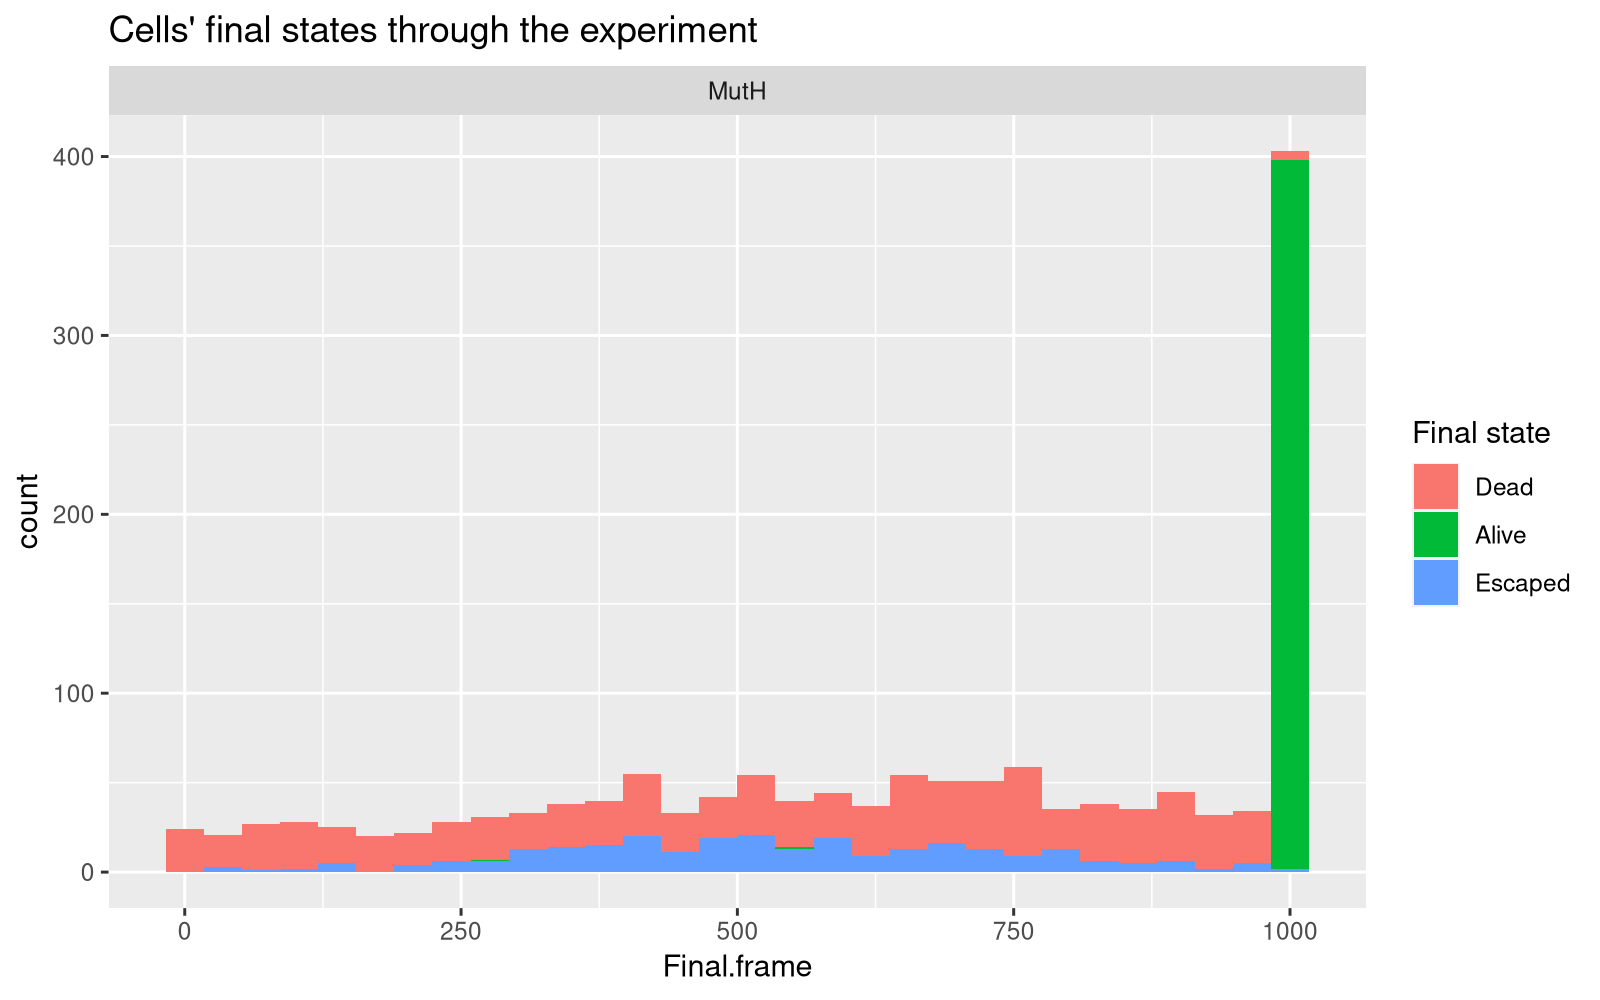

In [9]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
p <- ggplot(mortality_MutH, aes(x=Final.frame, fill=Final.state)) +
     geom_histogram(bins = 30) +
     ggtitle("Cells' final states through the experiment") + 
     scale_fill_discrete(name = "Final state", labels = c("Dead", "Alive", "Escaped")) +
     facet_wrap(. ~ Line)
p

ggsave(p, filename = "Img/Final_states_MutH.png", width = 5, height = 6, dpi = 400)

$\to$ De nombreuses bactéries ont survécu jusqu'à la fin des 1000 observations, les autres sont mortes ou se sont échappées auparavant.


On peut corriger l'effet des bactéries échappées en les supprimant du jeu de données

In [10]:
last_frame_MutH <- max(mortality_MutH$Final.frame)
survival_frame <- function(i, dataset){               # Proportion of surviving mother cells
  return (mean(dataset$Final.frame>=i, na.rm = T))
}

mortality_MutH_noEscape <- mortality_MutH[mortality_MutH$Final.state != 4,]

survival_MutH <- data.frame(Time = 0:last_frame_MutH/60*4,  # One frame every 4 minutes
                            Survival = sapply(0:last_frame_MutH, survival_frame, dataset=mortality_MutH),
                            # Correct for escaped bacteria
                            Survival_noEscape = sapply(0:last_frame_MutH, survival_frame, dataset=mortality_MutH_noEscape))

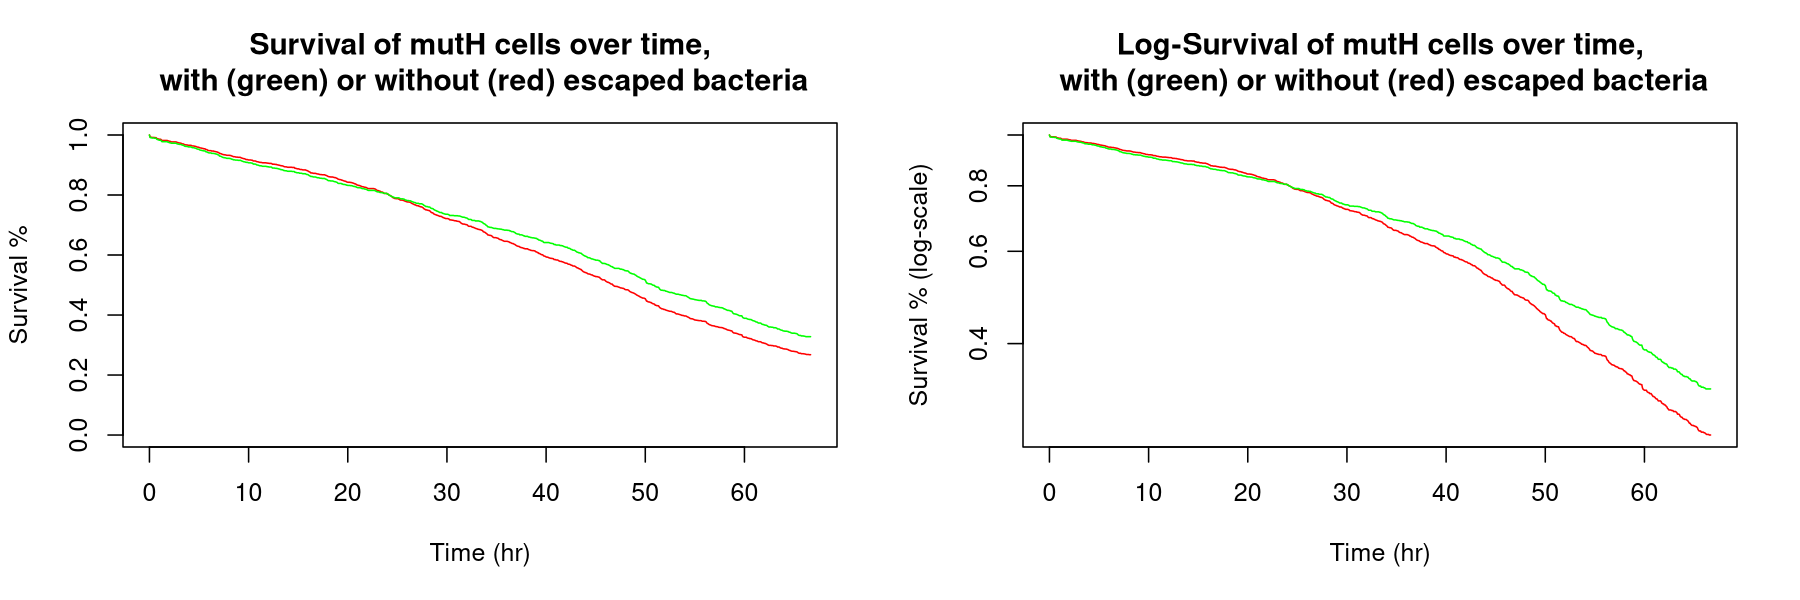

In [11]:
par(mfrow=c(1,2))
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 150)

plot(x=survival_MutH$Time,
     y=survival_MutH$Survival,
     type="l",
     col="red", 
     xlab = "Time (hr)", 
     ylab="Survival %", 
     ylim = c(0.0001,1),
     main = "Survival of mutH cells over time,\n with (green) or without (red) escaped bacteria")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col="green")

plot(x=survival_MutH$Time,
     y=survival_MutH$Survival,
     type="l",
     col="red",
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)", 
     # ylim = c(0.1,1), 
     log="y",
     main = "Log-Survival of mutH cells over time,\n with (green) or without (red) escaped bacteria")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col="green")

$\to$ On observe après une ~40 heures une accélération des morts, probablement due à la sénescence des bactéries

#### All lines


Idem avec les 5 lignées de bactéries utilisées

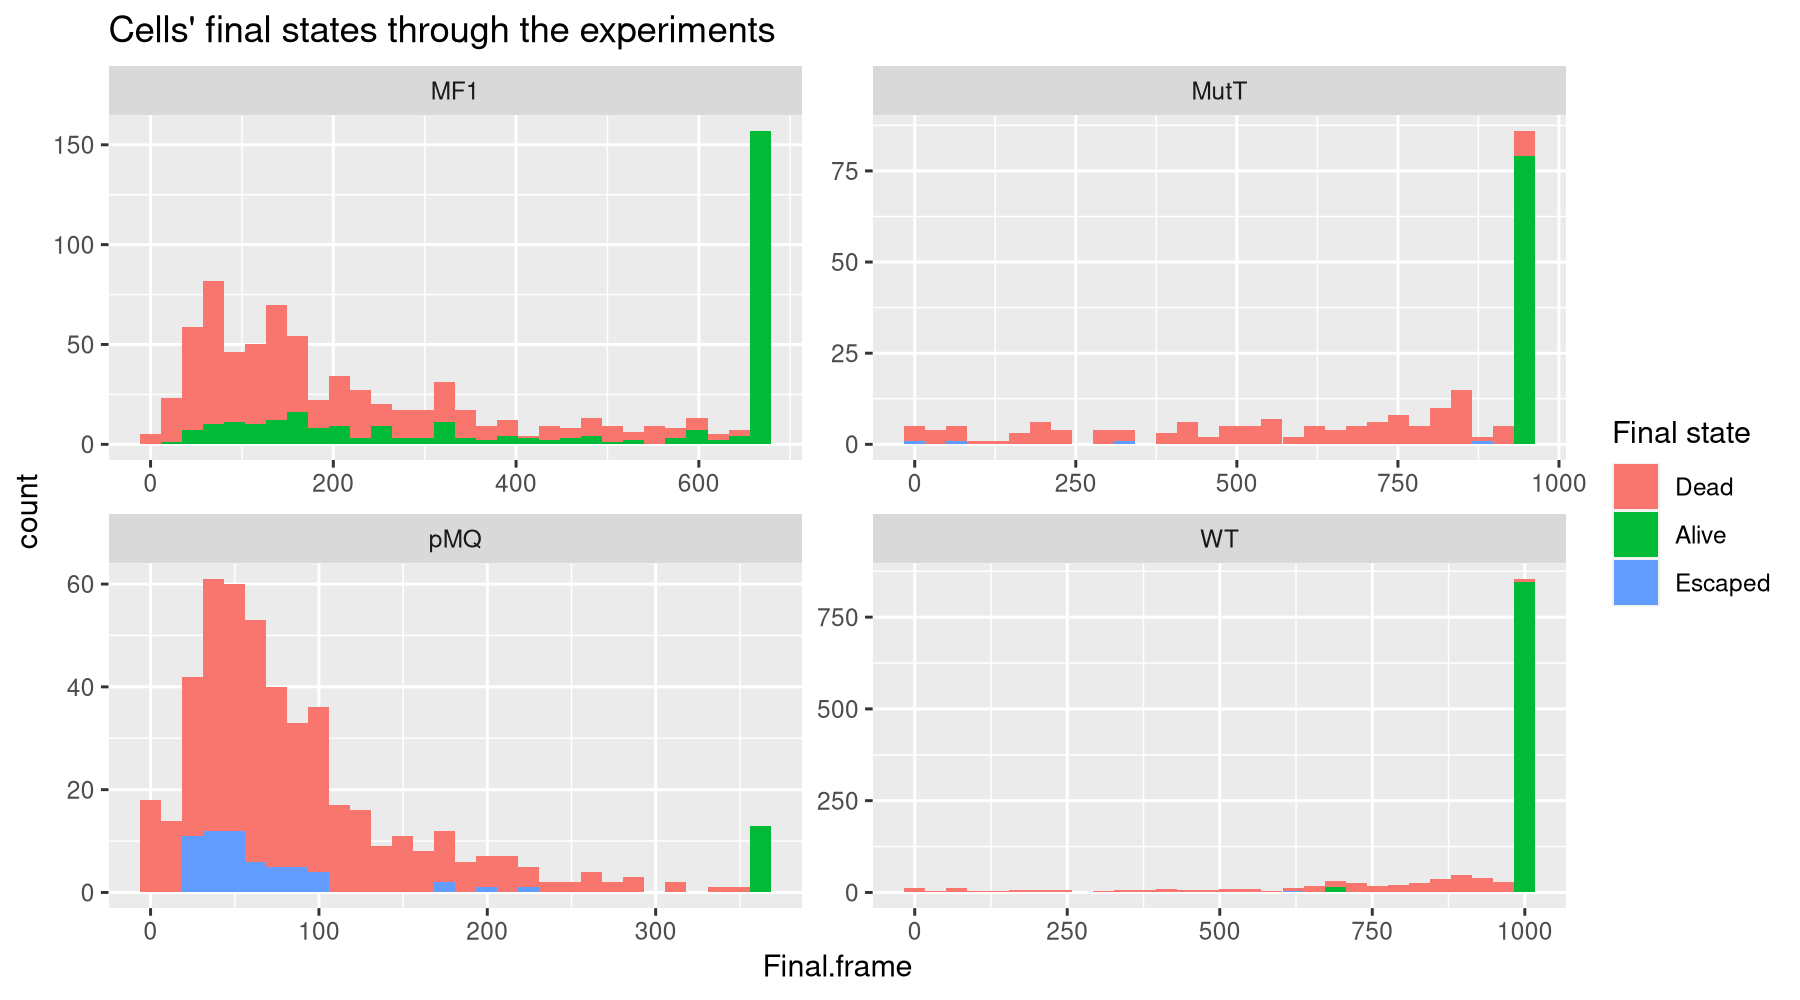

In [12]:
options(repr.plot.width = 9, repr.plot.height = 5, repr.plot.res = 200)

mortality_combined <- rbind(mortality_WT[,-c(1,2)], mortality_MutT, mortality_MF1, mortality_pMQ)

p <- ggplot(mortality_combined, aes(x=Final.frame, fill=Final.state)) +
            geom_histogram(bins = 30) +
            ggtitle("Cells' final states through the experiments") + 
            scale_fill_discrete(name = "Final state", labels = c("Dead", "Alive", "Escaped")) +
            facet_wrap(. ~ Line, scales="free", nrow = 2)
p

$\to$ Plus les lignées lignées présentent des taux de mutations plus élevés (pMQ > MF1 > mutT > WT), plus des cellules meurent rapidement

**QUESTION 2 : Comment se fait-il qu'avec MF1 uniquement on trouve des cellules de type "survie jusqu'au bout de l'expérience" tout au long de l'expérience ? Les cellules échappées ont-elles été mal classées ?**

En plus de retirer les cellules échappées, on peut essayer de corriger l'effet de la sénescence supposant que les bactéries WT n'auront qu'un nombre négligeable de mutations pendant l'expérience et donc mourront uniquement à cause de leur âge

In [13]:
last_frame_WT <- max(mortality_WT$Final.frame)
last_frame_MutT <- max(mortality_MutT$Final.frame)
last_frame_MF1 <- max(mortality_MF1$Final.frame)
last_frame_pMQ <- max(mortality_pMQ$Final.frame)

mortality_WT_noEscape <- mortality_WT[mortality_WT$Final.state != 4,]
mortality_MutT_noEscape <- mortality_MutT[mortality_MutT$Final.state != 4,]
mortality_MF1_noEscape <- mortality_MF1[mortality_MF1$Final.state != 4,]
mortality_pMQ_noEscape <- mortality_pMQ[mortality_pMQ$Final.state != 4,]

survival_WT <- data.frame(Time = 0:last_frame_WT/60*4,  # One frame every 4 minutes
                          Survival = sapply(0:last_frame_WT, survival_frame, dataset=mortality_WT),
                          Survival_noEscape = sapply(0:last_frame_WT, survival_frame, dataset=mortality_WT_noEscape))
survival_MutT <- data.frame(Time = 0:last_frame_MutT/60*4, 
                            Survival = sapply(0:last_frame_MutT, survival_frame, dataset=mortality_MutT),
                            Survival_noEscape = sapply(0:last_frame_MutT, survival_frame, dataset=mortality_MutT_noEscape))
survival_MF1 <- data.frame(Time = 0:last_frame_MF1/60*4, 
                           Survival = sapply(0:last_frame_MF1, survival_frame, dataset=mortality_MF1),
                           Survival_noEscape = sapply(0:last_frame_MF1, survival_frame, dataset=mortality_MF1_noEscape))
survival_pMQ <- data.frame(Time = 0:last_frame_pMQ/60*4, 
                           Survival = sapply(0:last_frame_pMQ, survival_frame, dataset=mortality_pMQ),
                           Survival_noEscape = sapply(0:last_frame_pMQ, survival_frame, dataset=mortality_pMQ_noEscape))

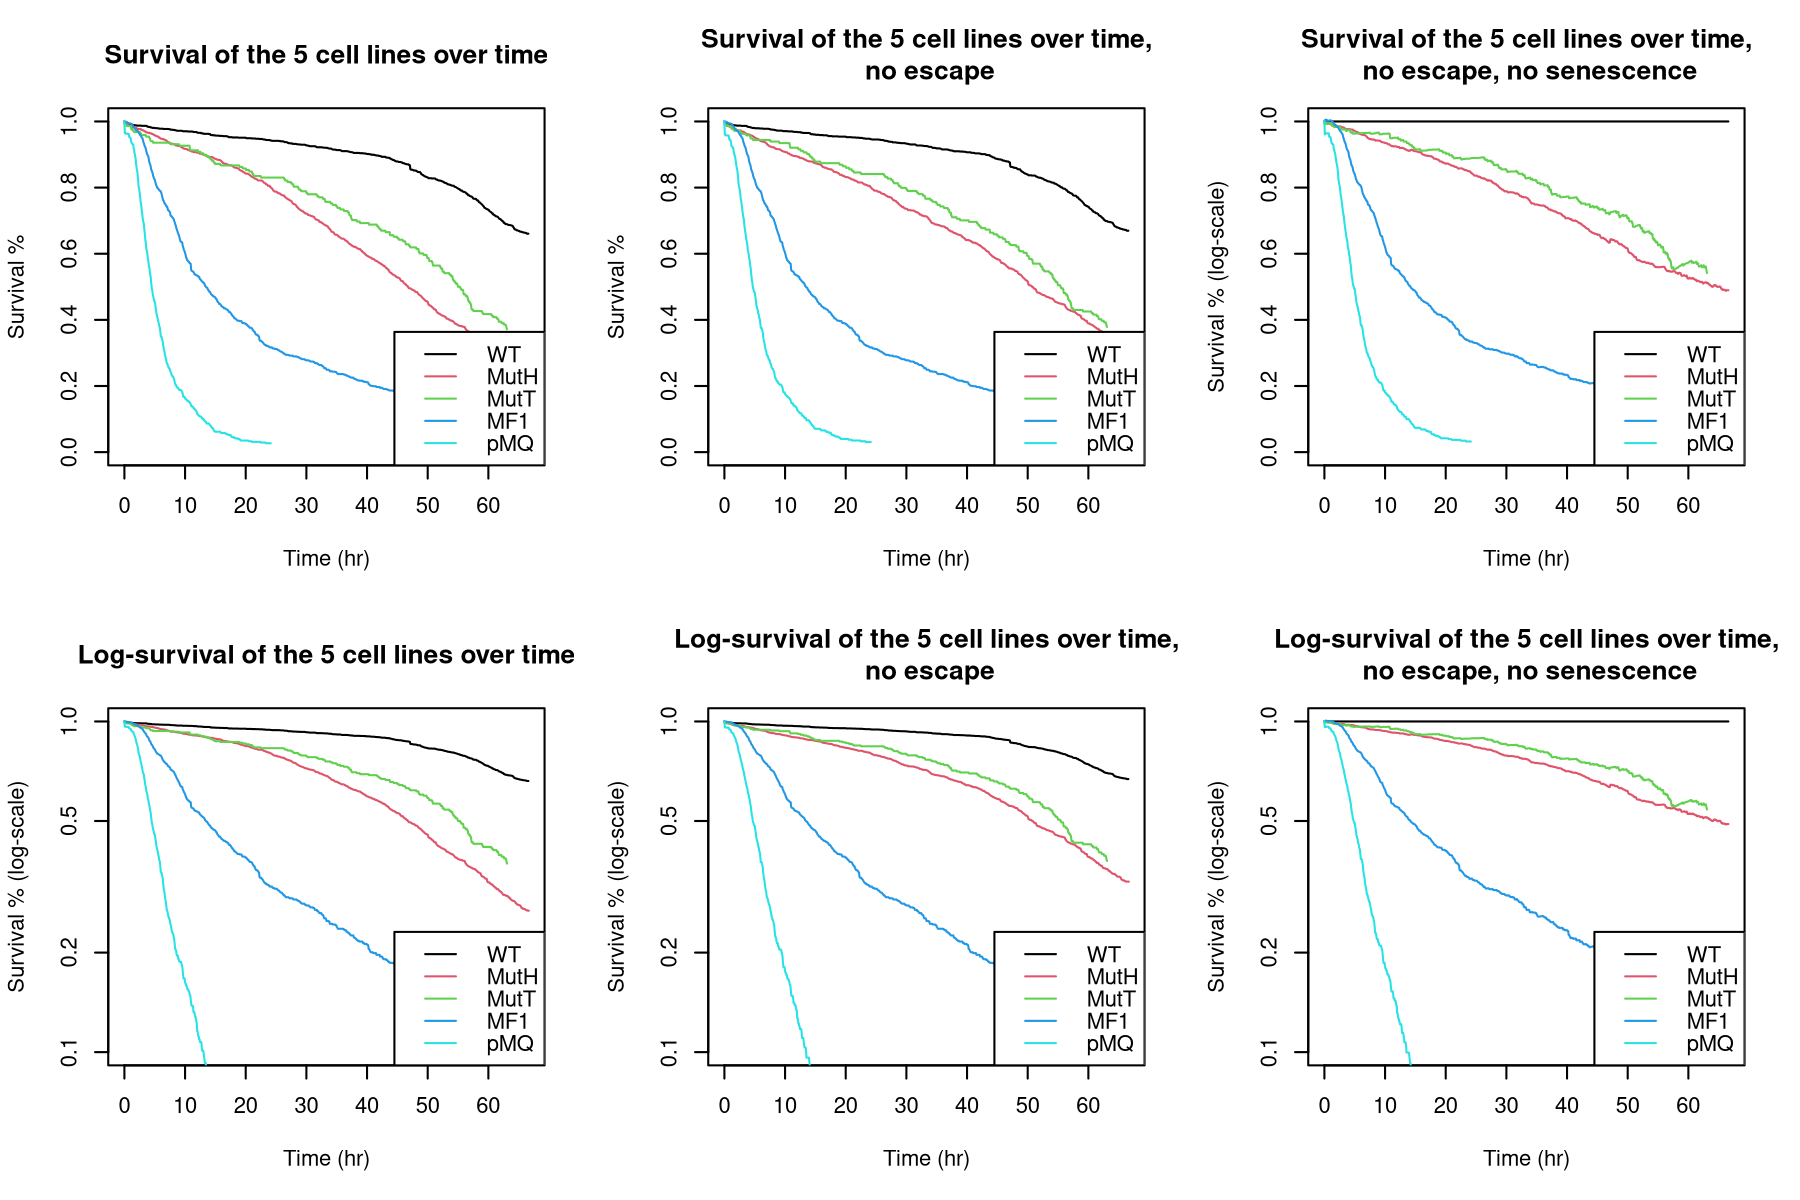

In [14]:
#png("Img/Survival.png", width = 1600, height = 1000, res = 150)

par(mfrow=c(2,3))
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200)

plot(x=survival_WT$Time,
     y=survival_WT$Survival,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival %", 
     ylim = c(0,1),
     main = "Survival of the 5 cell lines over time")
lines(x=survival_MutH$Time, y=survival_MutH$Survival, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival %", 
     ylim = c(0,1),
     main = "Survival of the 5 cell lines over time,\n no escape")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape/survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)",
     ylim = c(0,1),
     main = "Survival of the 5 cell lines over time,\n no escape, no senescence")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutH$Survival_noEscape)], col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutT$Survival_noEscape)], col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MF1$Survival_noEscape)], col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_pMQ$Survival_noEscape)], col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)",
     ylim = c(0.1,1),
     log = "y", 
     main = "Log-survival of the 5 cell lines over time")
lines(x=survival_MutH$Time, y=survival_MutH$Survival, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-survival of the 5 cell lines over time,\n no escape")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape/survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-survival of the 5 cell lines over time,\n no escape, no senescence")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutH$Survival_noEscape)], col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutT$Survival_noEscape)], col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MF1$Survival_noEscape)], col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_pMQ$Survival_noEscape)], col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

#dev.off()

$\to$ Comme dans l'article on retrouve bien des taux de survie décroissant exponentiellement au cours du temps, ainsi que l'on peut l'attendre si les mutations létales apparaissent selon un processus de poisson. Cela se vérifie dans les ~40 premières heures si on ne corrige pas pour la sénescence, et jusqu'au bout de l'expérience sinon (pour mutH notamment).

### Growth rates

Regardons maintenant les taux de croissance mesurés dans chacun des microcanaux, afin de répliquer le calcul des moments de la DFE

#### MutH

In [15]:
head(microMA_MutH[,1:9])

,time,generation,growth.rate,time.1,generation.1,growth.rate.1,time.2,generation.2,growth.rate.2
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
3,0,1,0.03526965,0,1,0.03202591,0,1,0.02811950
4,4,1,0.03526965,4,1,0.03202591,4,1,0.02811950
5,8,2,0.03247045,8,1,0.03202591,8,2,0.02680181
6,12,2,0.03247045,12,1,0.03202591,12,2,0.02680181
7,16,2,0.03247045,16,2,0.03367152,16,2,0.02680181
8,20,2,0.03247045,20,2,0.03367152,20,2,0.02680181


In [16]:
summary(microMA_MutH[,1:9])

      time        generation      growth.rate          time.1    
 Min.   :   0   Min.   :  1.00   Min.   :0.01835   Min.   :   0  
 1st Qu.: 999   1st Qu.: 45.00   1st Qu.:0.02770   1st Qu.: 999  
 Median :1998   Median : 90.00   Median :0.02883   Median :1998  
 Mean   :1998   Mean   : 90.82   Mean   :0.02974   Mean   :1998  
 3rd Qu.:2997   3rd Qu.:136.00   3rd Qu.:0.03127   3rd Qu.:2997  
 Max.   :3996   Max.   :183.00   Max.   :0.07248   Max.   :3996  
  generation.1   growth.rate.1         time.2      generation.2   
 Min.   :  1.0   Min.   :0.01148   Min.   :   0   Min.   :  1.00  
 1st Qu.: 36.0   1st Qu.:0.01650   1st Qu.: 999   1st Qu.: 48.75  
 Median : 63.0   Median :0.01753   Median :1998   Median : 97.00  
 Mean   : 63.8   Mean   :0.01859   Mean   :1998   Mean   : 91.61  
 3rd Qu.: 92.0   3rd Qu.:0.01944   3rd Qu.:2997   3rd Qu.:140.00  
 Max.   :122.0   Max.   :0.03386   Max.   :3996   Max.   :165.00  
 growth.rate.2       
 Min.   :-0.0009553  
 1st Qu.: 0.0252990  
 Me

Quelques exemples d'évolution du taux de croissance au cours de l'expérience

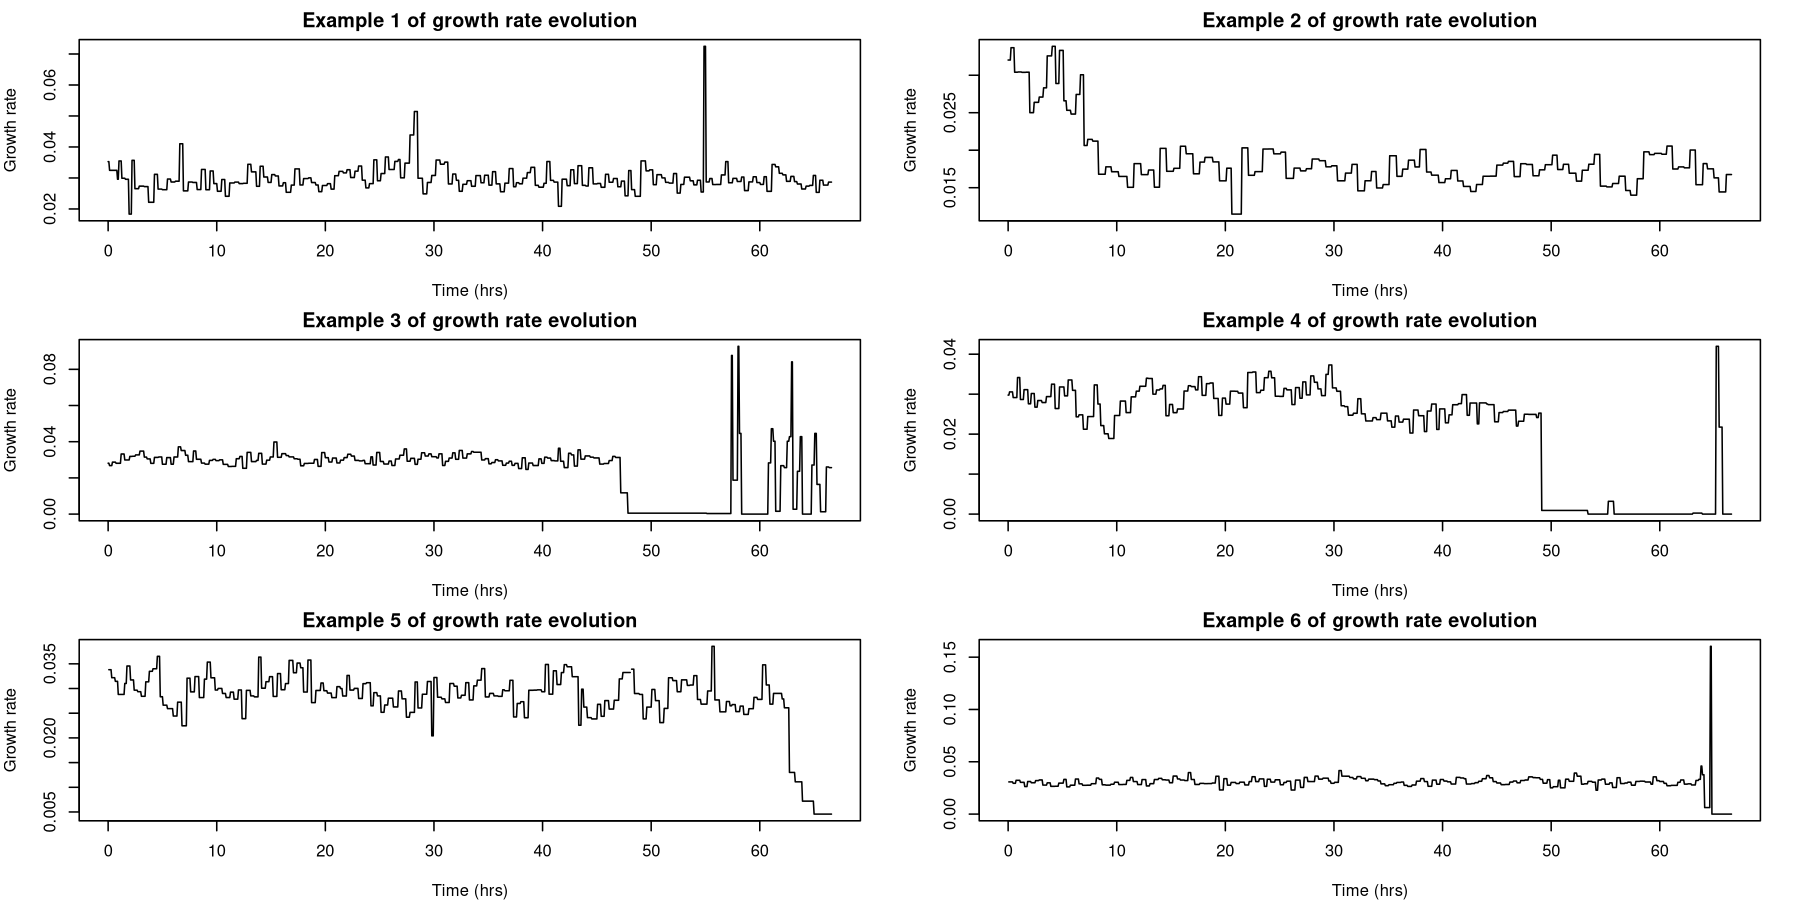

In [17]:
#png("Img/Growth_rates_examples.png", width = 800, height = 400)

microMA_MutH_growthRates <- microMA_MutH[seq(3, dim(microMA_MutH)[2], 3)]
microMA_MutH_growthRates[microMA_MutH_growthRates<0] <- 0  # Set negative growth rates to 0

par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:6){
    plot(microMA_MutH$time/60, microMA_MutH_growthRates[, i], type="l", xlab = "Time (hrs)", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

#dev.off()

$\to$ Les observations sont très bruitées, avec des pics aberrants (ex 1), des cellules apparemment mortes qui croissent à nouveau (ex 3-4).

Calculons les espérances des moments de Wt, qui vont être utilisés dans le calcul de :$$E_n(t):=\sum_{k=1}^n\binom{k}{n}(-1)^k\ln\big(\mathbb{E}\big[W_t^k\big]\big)=\big(\lambda\mathbb{E}\big[s^n\big]\big)t$$

In [18]:
moment_expectation <- function(k, dataset){
  return (rowMeans(dataset**k, na.rm = T))
}

k_values <- 1:10
moments_expectations_MutH <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_MutH_growthRates))
names(moments_expectations_MutH) <- paste("k.", k_values, sep = "")

head(moments_expectations_MutH)

,k.1,k.2,k.3,k.4,k.5,k.6,k.7,k.8,k.9,k.10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.03250712,0.0017362311,2.698378e-04,8.237702e-05,3.071159e-05,1.239086e-05,5.228312e-06,2.269559e-06,1.003748e-06,4.495617e-07
4,0.03209952,0.0015663271,2.167729e-04,6.427495e-05,2.388514e-05,9.633859e-06,4.064897e-06,1.764528e-06,7.803905e-07,3.495236e-07
5,0.03108476,0.0010832813,4.952009e-05,3.714617e-06,4.312110e-07,6.107275e-08,9.286288e-09,1.455587e-09,2.323287e-10,3.758676e-11
6,0.03051039,0.0010039712,3.821597e-05,1.992637e-06,1.593285e-07,1.733276e-08,2.165219e-09,2.856654e-10,3.864048e-11,5.302090e-12
7,0.03016438,0.0009655447,3.399317e-05,1.495474e-06,9.803644e-08,9.590835e-09,1.173708e-09,1.574574e-10,2.193224e-11,3.109624e-12
8,0.02974964,0.0009280131,3.095281e-05,1.242705e-06,7.609726e-08,7.610804e-09,9.889847e-10,1.397301e-10,2.018966e-11,2.934855e-12


#### WT

Idem pour WT

In [19]:
head(microMA_WT[,1:9])

,time,generation,growth.rate,time.1,generation.1,growth.rate.1,time.2,generation.2,growth.rate.2
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
3,0,1,0.01553294,0,1,NA,0,1,NA
4,4,1,0.01553294,4,2,0.03227775,4,2,0.03030216
5,8,2,0.03122056,8,2,0.03227775,8,2,0.03030216
6,12,2,0.03122056,12,2,0.03227775,12,2,0.03030216
7,16,2,0.03122056,16,2,0.03227775,16,2,0.03030216
8,20,2,0.03122056,20,2,0.03227775,20,2,0.03030216


In [20]:
microMA_WT_growthRates <- microMA_WT[seq(3, dim(microMA_WT)[2], 3)]
microMA_WT_growthRates[microMA_WT_growthRates < 0] <- 0  # Set negative growth rates to 0

k_values <- 1:10
moments_expectations_WT <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_WT_growthRates))
names(moments_expectations_WT) <- paste("k.", k_values, sep = "")

head(moments_expectations_WT)

,k.1,k.2,k.3,k.4,k.5,k.6,k.7,k.8,k.9,k.10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.04219302,0.003542421,5.795390e-04,1.352807e-04,3.742967e-05,1.151046e-05,3.827929e-06,1.352757e-06,5.009010e-07,1.920607e-07
4,0.03983673,0.003093899,4.798407e-04,1.098080e-04,3.017507e-05,9.256392e-06,3.075508e-06,1.086509e-06,4.022710e-07,1.542376e-07
5,0.03578041,0.001957415,1.756805e-04,2.322704e-05,3.825659e-06,7.188368e-07,1.479571e-07,3.252985e-08,7.497951e-09,1.786866e-09
6,0.03198789,0.001330981,7.906234e-05,7.102732e-06,8.616417e-07,1.236043e-07,1.948140e-08,3.254160e-09,5.646228e-10,1.004824e-10
7,0.03016124,0.001077701,4.612796e-05,2.544906e-06,1.823724e-07,1.579636e-08,1.525249e-09,1.561459e-10,1.653093e-11,1.788138e-12
8,0.02937371,0.001001953,3.994537e-05,2.023432e-06,1.351320e-07,1.121521e-08,1.056148e-09,1.061002e-10,1.102687e-11,1.168994e-12


#### WT + MutH


Affichons comme dans l'annexe de l'article $E_n(t)=\big(\lambda\mathbb{E}\big[s^n\big]\big)t$ au cours du temps afin d'inférer les moments de $s$ à partir des pentes des droites que l'on devrait obtenir

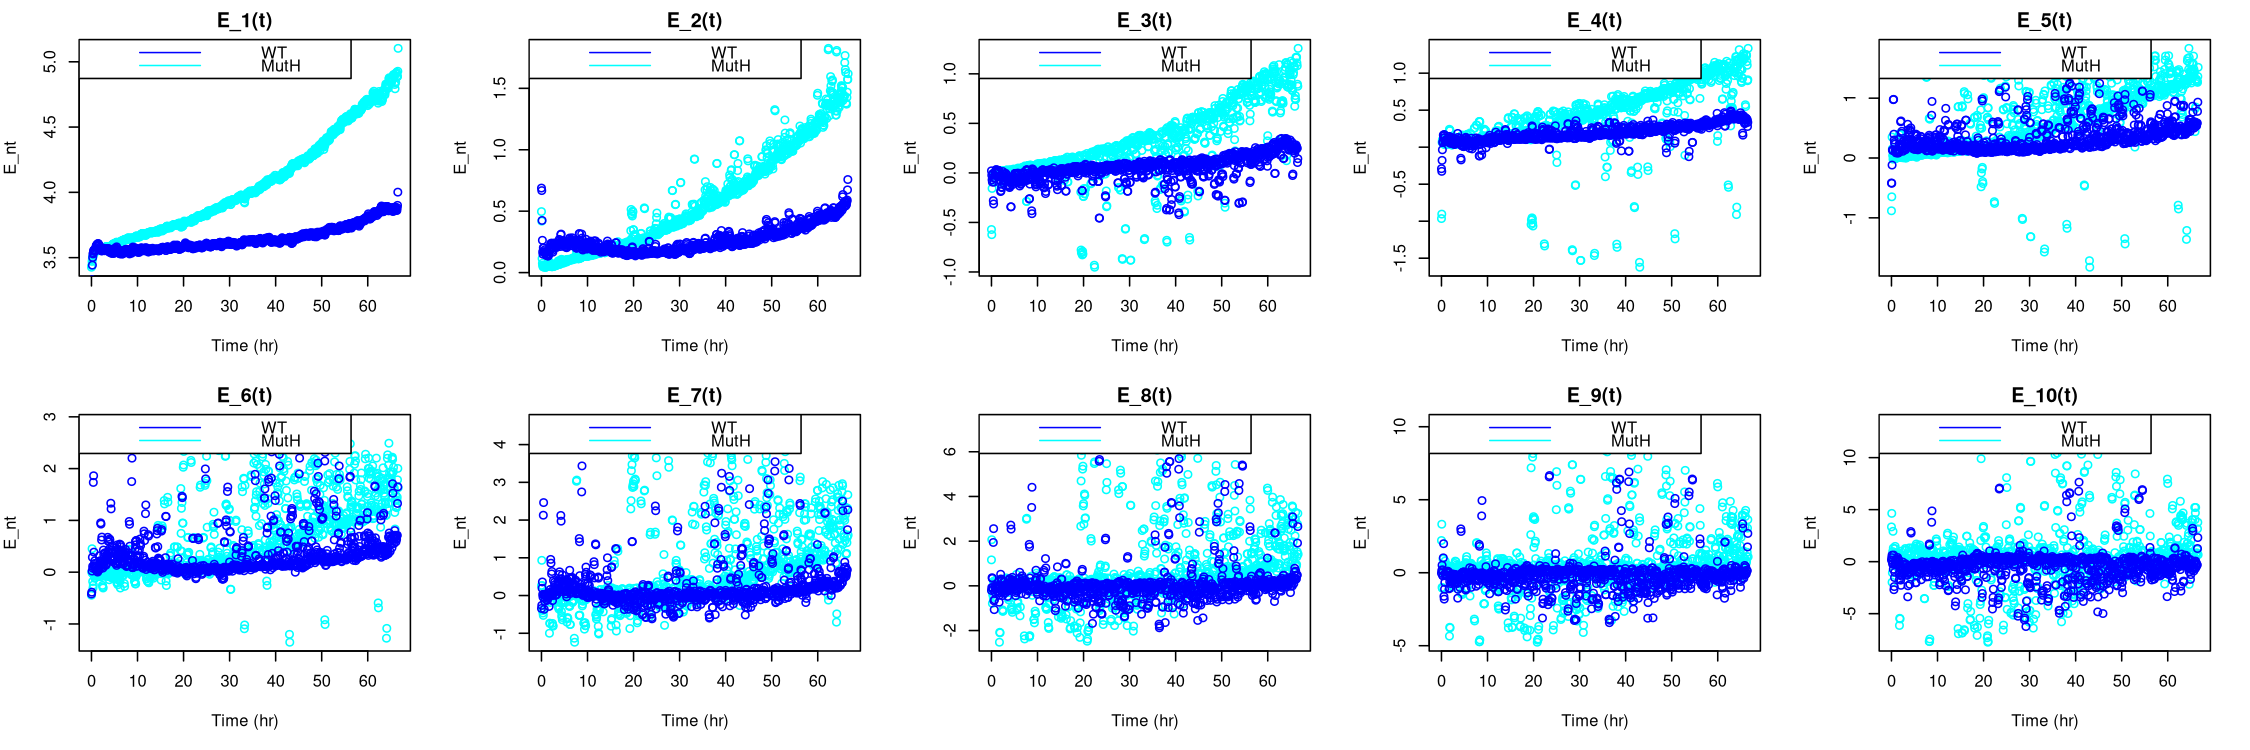

In [21]:
#png("Img/Growth_rates_E1-10.png", width = 800, height = 400)

log_choose <- function(k, n, moments_expectations){
  return ((-1)**k*choose(n,k)*log(moments_expectations[,k]))
}

par(mfrow = c(2,5), mar = c(5, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 5)

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_MutH))
  plot(x = microMA_MutH$time/60, 
       y = E_nt,
       xlab = "Time (hr)",
       col = "cyan",
       main = paste("E_", n, "(t)", sep = ""))
  
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_WT))
  points(x = microMA_WT$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       col = "blue",
       main = paste("E_", n, "(t)", sep = ""))
  
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=13)
}

#dev.off()

$\to$ Les pentes se courbent après 40h, on se restreint au début de l'expérience

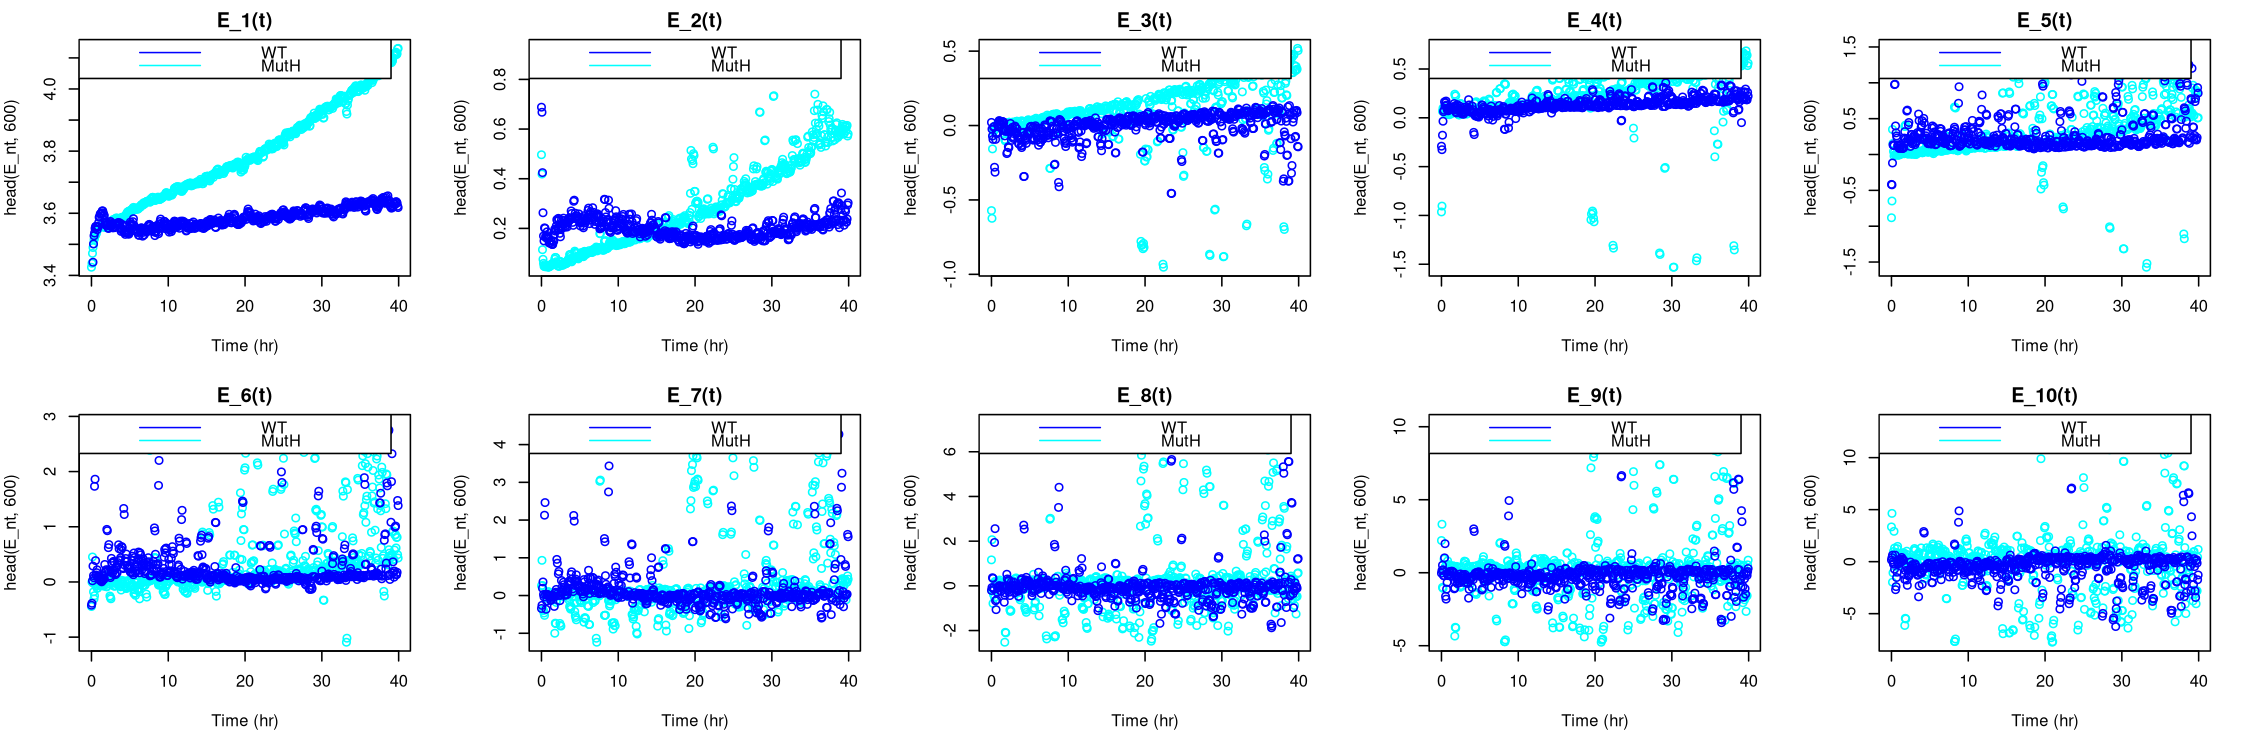

In [22]:
par(mfrow = c(2,5), mar = c(5, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 5)

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_MutH))
  plot(x = head(microMA_MutH$time/60, 600), 
       y = head(E_nt, 600), 
       xlab = "Time (hr)",
       col = "cyan",
       main = paste("E_", n, "(t)", sep = ""))
  
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_WT))
  points(x = head(microMA_WT$time/60, 600), 
       y = head(E_nt, 600), 
       xlab = "Time (hr)",
       col = "blue",
       main = paste("E_", n, "(t)", sep = ""))
  
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=13)
}

$\to$ On semble obtenir des droites, mais les données sont très bruitées. Essayons de recommencer en corrigeant d'abord les points aberrants et cellules mortes ou échappées.

#### Correct aberrant growth rates

On se base sur les corrections présentées dans l'annexe de l'article

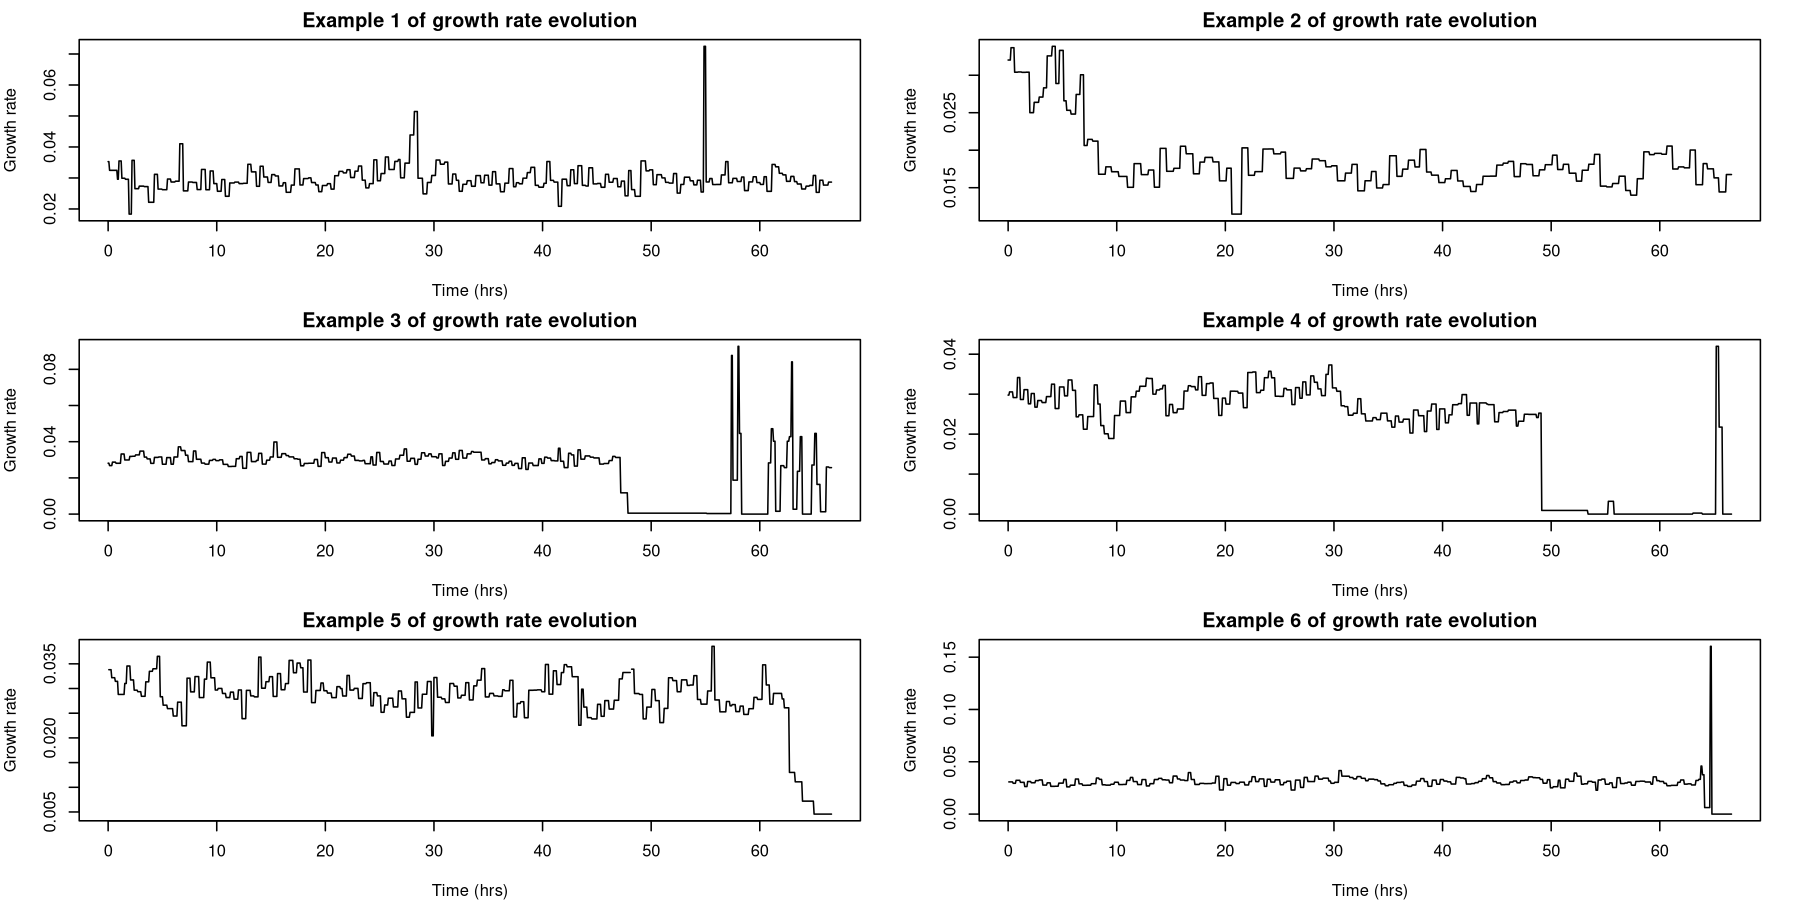

In [23]:
microMA_MutH_growthRates <- microMA_MutH[seq(3, dim(microMA_MutH)[2], 3)]
microMA_MutH_growthRates[microMA_MutH_growthRates<0] <- 0  # Set negative growth rates to 0

par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:6){
    plot(microMA_MutH$time/60, microMA_MutH_growthRates[, i], type="l", xlab = "Time (hrs)", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

The segmentation errors generated by image analysis can create aberrant, very low or
high growth rates. Therefore, we filtered our data in the following way :
   1. For each channel and each generation, we calculated the median of the growth rates for earlier generations ($M_{before}$) and subsequent generations ($M_{after}$).
   <br/>$\to$ ***Modification : ne prendre que les 100 générations précédentes et suivantes afin de détecter des aberrations plus "locales"***
   2. Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both $M_{before}$ and $M_{after}$ or much smaller than both $M_{before}$ and $M_{after}$.
   3. Therefore for each generation, we remove the value of the growth rate µ from the data if it differs from both $M_{after}$ and $M_{before}$ by more than a threshold value T.
   4. The value T was fixed at 30% of the average growth rate in the experiment, corresponding to the mean $\pm 2\times$standard deviation of the variable $\mu - M_{after}$
   5. The datasets for all strains (WT mutH, mutT,and MF1 such as plotted in Figure 3A and Figure S8)were all filtered using the same procedure.

In [ ]:
detect_aberrant_GR <- function(i, L){
    mu <- L[i]
    
    if (i>1){
        M_before <- median(L[max(1,i-100):(i-1)], na.rm = T)
    }else{
        M_before <- mu
    }
    
    if (i<length(L)){
        M_after <- median(L[i+1:min(length(L),i+100)], na.rm = T)
    }else{
        M_after <- mu
    }
    
    T <- 0.3*mean(L, na.rm = T)
    
    if (anyNA(c(mu, M_before, M_after))){ return (TRUE) }
    
    return((mu - M_before > T & mu - M_after > T)|(mu - M_before < -T & mu - M_after < -T))
}

microMA_MutH_growthRates_non_aberrant <- microMA_MutH_growthRates
for (i in 1:dim(microMA_MutH_growthRates)[2]){
    L <- microMA_MutH_growthRates[,i]
    microMA_MutH_growthRates_non_aberrant[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}

Quelques exemples d'évolution du taux de croissance, avant et après la suppression des valeurs aberrantes

ERROR: Error in plot(microMA_MutH_growthRates_non_aberrant[, i], type = "l", : objet 'microMA_MutH_growthRates_non_aberrant' introuvable


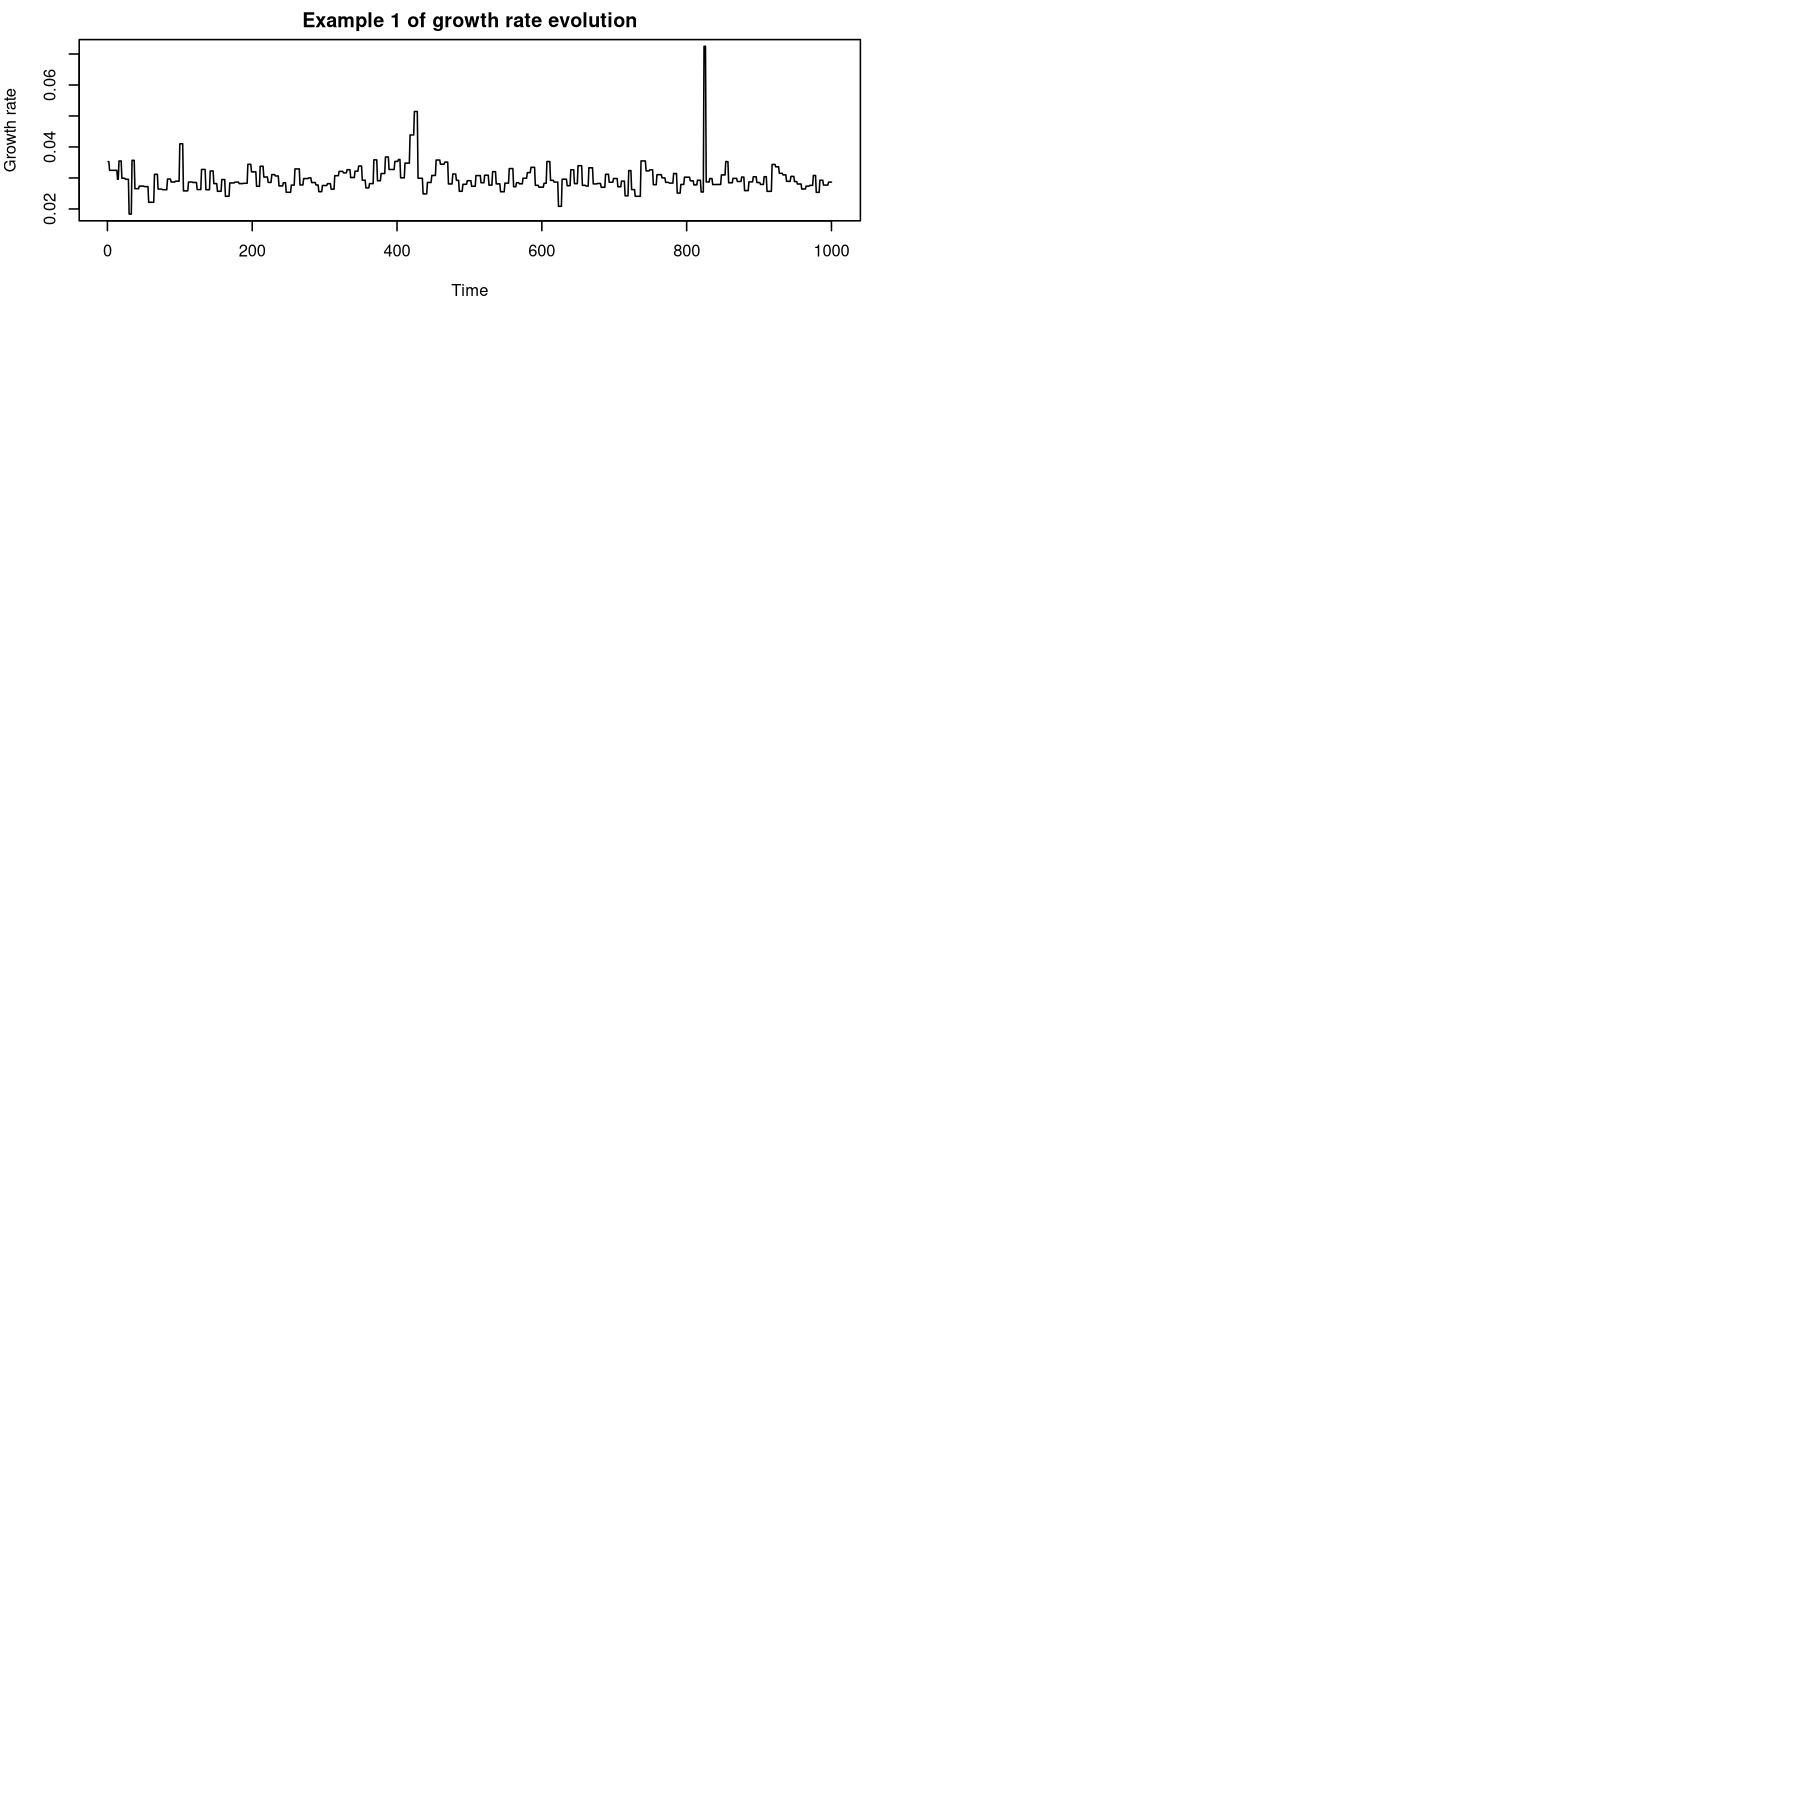

In [24]:
par(mfrow=c(6,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

for (i in 1:6){
    plot(microMA_MutH_growthRates[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
    plot(microMA_MutH_growthRates_non_aberrant[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of corrected growth rate evolution"))
}

$\to$ La correction semble bien fonctionner, à l'exception de l'exemple 3 ou des taux de croissance positifs sont gardés alors que la cellule semble morte depuis longtemps

Recalculer les moments de $W_t$ après correction

In [25]:
moments_expectations_non_aberrant_MutH <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_MutH_growthRates_non_aberrant))
names(moments_expectations_non_aberrant_MutH) <- paste("k.", k_values, sep = "")

ERROR: Error in is.data.frame(x): objet 'microMA_MutH_growthRates_non_aberrant' introuvable


Idem avec *WT*

In [ ]:
microMA_WT_growthRates_non_aberrant <- microMA_WT_growthRates
for (i in 1:dim(microMA_WT_growthRates)[2]){
    L <- microMA_WT_growthRates[,i]
    microMA_WT_growthRates_non_aberrant[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}

moments_expectations_non_aberrant_WT <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_WT_growthRates_non_aberrant))
names(moments_expectations_non_aberrant_WT) <- paste("k.", k_values, sep = "")

Réaffichons $E_n(t)$ au cours du temps pour *mutH* et *WT*

In [26]:
par(mfrow = c(2,5), mar = c(5, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 5)

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_non_aberrant_MutH))
  plot(x = microMA_MutH$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       col = "cyan",
       main = paste("E_", n, "(t)", sep = ""))
  
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_non_aberrant_WT))
  points(x = microMA_WT$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       col = "blue",
       main = paste("E_", n, "(t)", sep = ""))
  
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=13)
}

ERROR: Error in sapply(1:n, log_choose, n = n, moments_expectations = moments_expectations_non_aberrant_MutH): objet 'moments_expectations_non_aberrant_MutH' introuvable


$\to$ Les résultats sont bien moins bruités, mais ne prennent pas encore en compte les cellules mortes au cours de l'expérience

Death of slowly growing cells induces noise in DFE estimation. Therefore,
to estimate the DFE’s first moments we used a subset of the data :
   1. Restricted in time (time points before 40 hours)
   <br/>$\to$ ***Modification : nous avons également retiré les 40 premières minutes qui sont assez bruitées***
   2. Containing only cells that do not die on this restricted time window (only channels where the mother cell is still alive at 44 hours). For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data.

##### MutH

In [ ]:
microMA_MutH_channels_GR <- microMA_MutH_channels[,1:round(dim(microMA_MutH_channels)[2]/3)*3]
microMA_MutH_channels_GR[1:5]

Extrayons l'état final et le cadre de vue de chaque cellule

In [ ]:
microMA_MutH_final <- sapply(microMA_MutH_channels_GR, 
                             function(GR){mortality_MutH[mortality_MutH$Field.view == GR[1] &
                                                         mortality_MutH$Microchannel == GR[2], c(3,4)]})
microMA_MutH_final[,1:5]

Supprimons les données des cellules mortes ou échappées

In [ ]:
microMA_MutH_growthRates_clean <- microMA_MutH_growthRates_non_aberrant

for (i in which(microMA_MutH_final["Final.state",]!=2)){
    microMA_MutH_growthRates_clean[microMA_MutH_final[["Final.frame",i]]:1000,i] <- NA
}

Gardons entre 40 minutes et 40 heures

In [ ]:
time_window <- 10:600
microMA_MutH_growthRates_clean <- microMA_MutH_growthRates_clean[time_window,]

In [ ]:
#png("Img/Growth_rates_corrected_examples.png", width = 1600, height = 800, res = 150)

par(mfrow=c(3,3), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:3){
    plot(x = microMA_MutH$time/60, microMA_MutH_growthRates[, i], type="l", xlab = "Time (hrs)", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
    plot(x = microMA_MutH$time/60, microMA_MutH_growthRates_non_aberrant[, i], type="l", xlab = "Time (hrs)", ylab = "Growth rate", main = "Idem without aberrant points and dead cells")
    plot(x = microMA_MutH[time_window,]$time/60, microMA_MutH_growthRates_clean[, i], type="l", xlab = "Time (hrs)", ylab = "Growth rate", main = "Idem on a restricted time window")
}

#dev.off()

In [ ]:
moments_expectations_clean_MutH <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_MutH_growthRates_clean))
names(moments_expectations_clean_MutH) <- paste("k.", k_values, sep = "")

##### WT

In [ ]:
microMA_WT_channels_GR <- microMA_WT_channels[,1:round(dim(microMA_WT_channels)[2]/3)*3]

microMA_WT_final <- sapply(microMA_WT_channels_GR, 
                             function(GR){mortality_WT[mortality_WT$Field.view == GR[1] &
                                                         mortality_WT$Microchannel == GR[2], c(3,4)]})
microMA_WT_final

In [ ]:
microMA_WT_growthRates_clean <- microMA_WT_growthRates_non_aberrant

# Remove data for dead or escaped cells
for (i in which(microMA_WT_final["Final.state",]!=2)){
    microMA_WT_growthRates_clean[microMA_WT_final[["Final.frame",i]]:999,i] <- NA
}

# Keep only between 40 minutes and 40 hours
microMA_WT_growthRates_clean <- microMA_WT_growthRates_clean[time_window,]

head(microMA_WT_growthRates_clean[1:5])

In [ ]:
moments_expectations_clean_WT <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_WT_growthRates_clean))
names(moments_expectations_clean_WT) <- paste("k.", k_values, sep = "")

##### WT + MutH

In [ ]:
#png("Img/Growth_rates_corrected_E1-4.png", width = 1600, height = 800, res = 150)

par(mfrow = c(2,2), mar = c(5, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6)

N <- 4
slopes <- data.frame(n = 1:N,
                     slope_MutH = rep(NA,N), std_err_MutH = rep(NA,N), r_squared_MutH = rep(NA,N), 
                     slope_WT = rep(NA,N), std_err_WT = rep(NA,N), r_squared_WT = rep(NA,N))

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_WT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_WT)),
                     E_nt_MutH = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutH)))
    
    plot(x = df_n$time, 
         y = df_n$E_nt_WT, 
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""),
         col = "blue",
         main = paste("Estimation of moment", n),
         ylim = range(df_n[,c(2,3)]))
    
    lin_reg_WT <- lm(E_nt_WT~time, data=df_n)
    abline(lin_reg_WT, col="red", lty=2, lwd=3)
    slopes[n,5:7] <- c(summary(lin_reg_WT)$coefficients[2,c(1,2)]/60, summary(lin_reg_WT)$r.squared)
  
    points(x = df_n$time, 
           y = df_n$E_nt_MutH, 
           xlab = "Time (hr)",
           ylab = paste("E_", n, "(t)", sep = ""),
           col = "cyan",
           main = paste("Estimation of moment", n))
    
    lin_reg_MutH <- lm(E_nt_MutH~time, data=df_n)
    abline(lin_reg_MutH, col="red", lwd=3)
    slopes[n,2:4] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared)
    
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=5)
}

#dev.off()

$\to$ Les points tracés s'alignent très approximativement sur des droites, mais d'allures différentes de celles de l'article (plus pentues, WT moins horizontale) :

![](Img/Moments_estimation.png)

De plus les pentes sont aussi très différentes, et notamment diminuent très peu pour des moments croissants :

In [ ]:
signif(slopes, digits=2)

![](Img/Slope_values.png)

***QUESTION 3 : Avez-vous une idée de ce que nous avons pu louper dans la réplication des résultats pour obtenir des résultats aussi différents ? À quelle expérience mutH (1-2-3) dans le tableau ci-dessus doivent correspondre les données fournies avec l'article ?***

## Mutation Visualization experiment : data_MV

### Files description

"interarrival_times_figure2" gives the inter-arrival times between successive foci (in minutes) for a mutH experiment

In [ ]:
interarrival_times <- read.csv2("doi_10/All_data/data_MV/interarrival_times_figure2.csv")
names(interarrival_times) <- c("inter_time")
head(interarrival_times)
hist(interarrival_times$inter_time,breaks=40)

x=1:100
y=sapply(x,function(x) 400*exp(-0.1*x))
lines(x,y,col=2)


$\to$ les durées entre deux mutations suivent une loi exponentielle : les mutations apparaissent selon un processus de Poisson.

"size_and_focusfirstdetection_figure2E" gives the size and number of new foci for all mother cells at all times, for a mutH experiment (number new foci at time ti = number of foci that arose between ti-1 and ti)


In [ ]:
size_nfoci <- read.csv2("./doi_10/All_data/data_MV/size_and_focusfirstdetection_figure2E.csv")
names(size_nfoci)=c("cell_size","nfoci")
head(size_nfoci)
summary(size_nfoci)

In [ ]:
sum(size_nfoci$nfoci==1)
sum(size_nfoci$nfoci==2)
sum(size_nfoci$nfoci==3)

$\to$ Dans la plupart des cellules avec mutation, il y a au plus un focus : ainsi, il est assez rare que plusieurs mutations apparaissent au cours de la même génération. On peut donc s'intéresser aux changements de fitness d'une génération à la génération suivante en supposant qu'une seule mutation a eu lieu. (Remarque : en fait, cela ne fonctionne pas à cause du bruit lors des mesures.)

" size_growthrate_focusfirstdetection_figure2G" gives the size, growth rate and number of new foci for all mother cells at all times, for  mutH (2 experiments are pooled; number new foci at time ti = number of foci that arose between ti-1 and ti)


In [ ]:
size_grate_nfoci<-read.csv2("doi_10/All_data/data_MV/size_growthrate_focusfirstdetection_figure2G.csv")

names(size_grate_nfoci)=c("size","grate","nfoci")
head(size_grate_nfoci)
summary(size_grate_nfoci)

# Data Analysis

## Stepwise growth rate drops

Nous voulons observer directement les variations des taux de croissance dues aux effets combinés des mutations et de la stochasticité des mesures, et si possible corriger cette dernière afin d'obtenir une estimation directe de la DFE.

In [ ]:
dim(microMA_MutH_growthRates)
head(microMA_MutH_growthRates)

### Gross drops : W-W'

Commençons par les variations brutes du taux de croissance dans tous les canaux, en supprimant les mesures constantes correspondant aux taux de croissance moyennés sur une génération ou aux cellules mortes.

In [ ]:
#get_drops_col <- function(k, dataset){
#    cur_col <- dataset[,k]
#    n <- length(cur_col)
#    ### tu pourras m'expliquer comment ça marche sapply ? 
#    #res <- sapply(1:n-1,
#    #              function(i) cur_col[i+1]-cur_col[i])
#    res<-cur_col
#    for(i in 1:n-1){
#        res[i]<-cur_col[i+1]-cur_col[i]
#    }
#    return (res[res!=0])
#}
#
#get_drops <- function(dataset){
#    ncol <- dim(dataset)[2]
#    res=get_drops_col(1,dataset) ### ugly : can't do better?
#    for(k in 2:ncol){
#        nouv=get_drops_col(k,dataset)
#        res=c(res,nouv)
#    }
#    return (res)
#}
#drops_MutH <- get_drops(microMA_MutH_growthRates)

drops_MutH <- -sapply(microMA_MutH_growthRates, diff)
drops_MutH <- drops_MutH[drops_MutH != 0 & is.finite(drops_MutH)]

length(drops_MutH)
summary(drops_MutH)
#hist(drops_MutH,breaks=5000,
#    main="Distribution of gross growth rate changes")
#hist(drops_MutH,breaks=1000,
#     xlim=c(-0.02,0.02),
#    main="Distribution of gross growth rate changes - zoom")

In [ ]:
par(mfrow=c(1,2))
options(repr.plot.width = 12, repr.plot.height = 6)

limit = 0.011
hist(drops_MutH, breaks=5000, probability = TRUE, main="Distribution of gross growth rate changes")
hist(drops_MutH, breaks=5000, xlim=c(-0.03, 0.03), probability = TRUE, main="Distribution of gross growth rate changes - Zoom")
curve(dnorm(x, mean(drops_MutH[abs(drops_MutH)<limit]), sd(drops_MutH[abs(drops_MutH)<limit])), col = 3, add = TRUE)

# test de gaussianité :
drops_MutH_sd = sd(drops_MutH,na.rm=TRUE)
drops_MutH_mean = mean(drops_MutH,na.rm=TRUE)
drops_MutH_norm = (drops_MutH-drops_MutH_mean)/drops_MutH_sd

shapiro.test(drops_MutH_norm[1:5000])

$\to$ Cette répartition des chutes de taux de croissance bruts ne suit pas une distribution normale

### Relative drops : (W-W')/W

In [ ]:
wt_lim <- 5e-3   # growth rate limit before considering the cell dead
W <- microMA_MutH_growthRates
W[W<wt_lim] <- 0   # set very small growth rates to 0 (dead cell)

reldrops_MutH <- -sapply(W, diff)/W[-dim(W)[1],]
reldrops_MutH <- reldrops_MutH[reldrops_MutH != 0]    # remove constant growth rates
reldrops_MutH <- reldrops_MutH[is.finite(reldrops_MutH)]    # remove reborn dead cells (division by 0)

length(reldrops_MutH)
summary(reldrops_MutH)

In [ ]:
?dlogis

In [ ]:
par(mfrow=c(1,2))
options(repr.plot.width = 12, repr.plot.height = 6)

limit = 0.5
reldrops_MutH_dty <- hist(reldrops_MutH, breaks=10000, probability = TRUE, main="Distribution of relative growth rate changes")
hist(reldrops_MutH, breaks=10000, xlim=c(-1, 1), probability = TRUE, main="Distribution of relative growth rate changes - Zoom")
reldrops_MutH_norm_dty <- dnorm(reldrops_MutH_dty$mids, mean(reldrops_MutH[abs(reldrops_MutH)<limit]), sd(reldrops_MutH[abs(reldrops_MutH)<limit]))
lines(reldrops_MutH_dty$mids, reldrops_MutH_norm_dty, col = "green")
limit = 1.15
reldrops_MutH_norm_dty <- dnorm(reldrops_MutH_dty$mids, -0.02, sd(reldrops_MutH[abs(reldrops_MutH)<limit]))
lines(reldrops_MutH_dty$mids, reldrops_MutH_norm_dty*0.35, col = "red")

$\to$ Cette distribution des baisses de taux de croissance relatifs n'est pas non plus normale, même en excluant les forts effets des mutations dans les queues (par exemple les mutations létales produisant le pic à 1)

Si nous avions la distribution du bruit, nous pourrions essayer de l'extraire de la distribution pour obtenir directement la DFE (comme ci-dessous pour la gaussienne rouge) :

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6)
plot(reldrops_MutH_dty$mids, reldrops_MutH_dty$density-reldrops_MutH_norm_dty*0.35, type="l", xlim=c(-1,1))
lines(c(-1,1), c(0,0), col="blue")

Inverser la moitié gauche de la distribution ne fonctionne pas non plus, la distribution est trop asymétrique :

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6)
hist(reldrops_MutH[reldrops_MutH > -0], breaks=100, xlim=c(-1, 1), col=alpha("red", 0.5), main="Distribution of relative growth rate changes - Zoom")
hist(reldrops_MutH[reldrops_MutH < -0 & reldrops_MutH > -1], breaks=100, xlim=c(-1, 1), col="green", add=T)
hist(-reldrops_MutH[reldrops_MutH < -0 & reldrops_MutH > -1], breaks=100, xlim=c(-1, 1), col=alpha("green", 0.3), add=T)